In [1]:
# ===========================================
# SECTION 1: Imports and Global Config
# ===========================================

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import itertools
import random
import os

# set seeds for reproducibility (not perfect but helps)
seedValue = 42
np.random.seed(seedValue)
tf.random.set_seed(seedValue)
random.seed(seedValue)
os.environ["PYTHONHASHSEED"] = str(seedValue)

print(tf.__version__)


2.19.0


In [2]:
# ===========================================
# SECTION 2: Data Loading and Preprocessing
# ===========================================

def loadData():
    (xTrain, yTrain), (xTest, yTest) = fashion_mnist.load_data()

    # expand dims for channels
    xTrain = xTrain.astype("float32") / 255.0
    xTest = xTest.astype("float32") / 255.0

    xTrain = np.expand_dims(xTrain, axis=-1)
    xTest = np.expand_dims(xTest, axis=-1)

    numClasses = len(np.unique(yTrain))

    yTrainCat = to_categorical(yTrain, numClasses)
    yTestCat = to_categorical(yTest, numClasses)

    xTrain, xVal, yTrainCat, yValCat = train_test_split(
        xTrain, yTrainCat, test_size=0.1, random_state=seedValue, stratify=yTrain
    )

    return xTrain, xVal, xTest, yTrainCat, yValCat, yTestCat, yTrain, yTest, numClasses

xTrain, xVal, xTest, yTrainCat, yValCat, yTestCat, yTrainRaw, yTestRaw, numClasses = loadData()

print("Train shape:", xTrain.shape)
print("Val shape:", xVal.shape)
print("Test shape:", xTest.shape)
print("Number of classes:", numClasses)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train shape: (54000, 28, 28, 1)
Val shape: (6000, 28, 28, 1)
Test shape: (10000, 28, 28, 1)
Number of classes: 10


In [3]:
# ===========================================
# SECTION 3: Model Builders
# ===========================================

def buildCnnModel(strideValue, numClasses):
    model = models.Sequential()

    # use an explicit Input layer (avoids warnings)
    model.add(layers.Input(shape=(28, 28, 1)))

    # first conv block
    model.add(layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides=(strideValue, strideValue),
        activation="relu"
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # second conv block
    model.add(layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides=(1, 1),
        activation="relu"
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # classifier head
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(numClasses, activation="softmax"))

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


def buildHybridModel(numClasses):
    modelInput = layers.Input(shape=(28, 28, 1))

    # CNN feature extractor
    x = layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides=(1, 1),
        activation="relu",
        padding="same"
    )(modelInput)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # shape now is (batch, 14, 14, 32)

    # treat spatial map as a sequence:
    # timeSteps = 14 * 14, features = 32
    x = layers.Reshape((-1, x.shape[-1]))(x)  # (batch, timeSteps, features)

    # Bi-LSTM over the sequence of patches
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.5)(x)
    outputLayer = layers.Dense(numClasses, activation="softmax")(x)

    model = models.Model(inputs=modelInput, outputs=outputLayer)

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [4]:
# ===========================================
# SECTION 4: Training Utility
# ===========================================

def trainModel(model, xTrain, yTrain, xVal, yVal, numEpochs=8, batchSize=128):
    history = model.fit(
        xTrain, yTrain,
        validation_data=(xVal, yVal),
        epochs=numEpochs,
        batch_size=batchSize,
        verbose=2
    )
    return history


In [6]:
# ===========================================
# SECTION 5: Build Models and Run Experiments
# ===========================================

numEpochs = 8
batchSize = 128

print("Building Model A (stride=2)...")
modelA = buildCnnModel(strideValue=2, numClasses=numClasses)

print("Building Model B (stride=1)...")
modelB = buildCnnModel(strideValue=1, numClasses=numClasses)

print("Building Model C (CNN + Bi-LSTM)...")
modelC = buildHybridModel(numClasses=numClasses)

print("\nTraining Model A (CNN stride=2)...")
historyA = trainModel(modelA, xTrain, yTrainCat, xVal, yValCat, numEpochs=numEpochs, batchSize=batchSize)

print("\nTraining Model B (CNN stride=1)...")
historyB = trainModel(modelB, xTrain, yTrainCat, xVal, yValCat, numEpochs=numEpochs, batchSize=batchSize)

print("\nTraining Model C (CNN + Bi-LSTM)...")
historyC = trainModel(modelC, xTrain, yTrainCat, xVal, yValCat, numEpochs=numEpochs, batchSize=batchSize)


Building Model A (stride=2)...
Building Model B (stride=1)...
Building Model C (CNN + Bi-LSTM)...

Training Model A (CNN stride=2)...
Epoch 1/8
422/422 - 7s - 16ms/step - accuracy: 0.6998 - loss: 0.8357 - val_accuracy: 0.8103 - val_loss: 0.5116
Epoch 2/8
422/422 - 1s - 3ms/step - accuracy: 0.8055 - loss: 0.5306 - val_accuracy: 0.8492 - val_loss: 0.4171
Epoch 3/8
422/422 - 1s - 3ms/step - accuracy: 0.8342 - loss: 0.4580 - val_accuracy: 0.8635 - val_loss: 0.3694
Epoch 4/8
422/422 - 1s - 3ms/step - accuracy: 0.8517 - loss: 0.4115 - val_accuracy: 0.8750 - val_loss: 0.3394
Epoch 5/8
422/422 - 1s - 3ms/step - accuracy: 0.8601 - loss: 0.3852 - val_accuracy: 0.8795 - val_loss: 0.3252
Epoch 6/8
422/422 - 1s - 3ms/step - accuracy: 0.8669 - loss: 0.3674 - val_accuracy: 0.8817 - val_loss: 0.3124
Epoch 7/8
422/422 - 1s - 3ms/step - accuracy: 0.8739 - loss: 0.3475 - val_accuracy: 0.8842 - val_loss: 0.3053
Epoch 8/8
422/422 - 2s - 4ms/step - accuracy: 0.8775 - loss: 0.3359 - val_accuracy: 0.8907 - va

In [7]:
# ===========================================
# SECTION 6: Evaluation on Test Set + Metrics
# ===========================================

def evaluateModel(model, xTest, yTestCat, modelName="Model"):
    testLoss, testAccuracy = model.evaluate(xTest, yTestCat, verbose=0)
    print(f"{modelName} - Test Loss: {testLoss:.4f}, Test Accuracy: {testAccuracy:.4f}")
    return testLoss, testAccuracy

lossA, accA = evaluateModel(modelA, xTest, yTestCat, modelName="Model A (stride=2 CNN)")
lossB, accB = evaluateModel(modelB, xTest, yTestCat, modelName="Model B (stride=1 CNN)")
lossC, accC = evaluateModel(modelC, xTest, yTestCat, modelName="Model C (CNN + Bi-LSTM)")


Model A (stride=2 CNN) - Test Loss: 0.3276, Test Accuracy: 0.8795
Model B (stride=1 CNN) - Test Loss: 0.2712, Test Accuracy: 0.8999
Model C (CNN + Bi-LSTM) - Test Loss: 0.4687, Test Accuracy: 0.8297


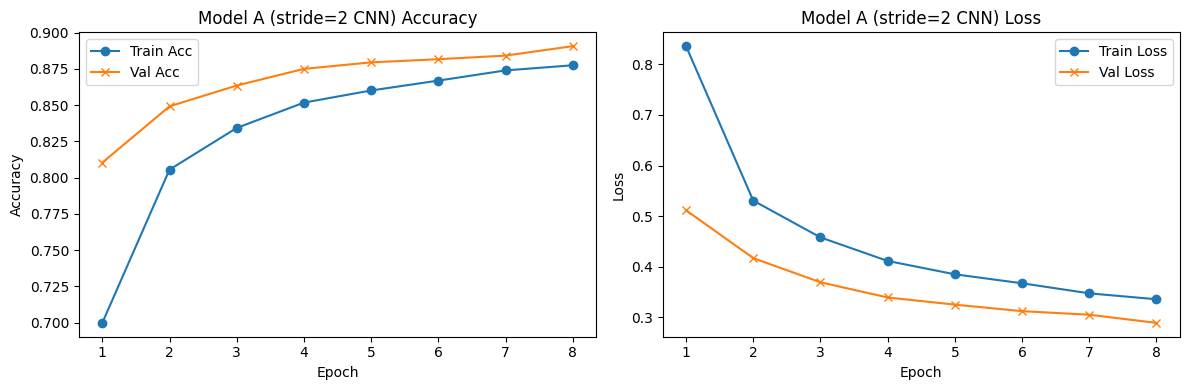

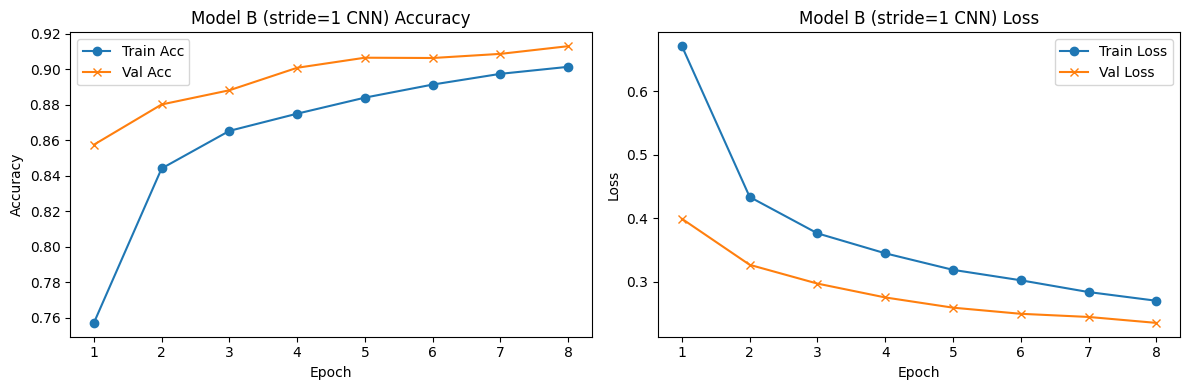

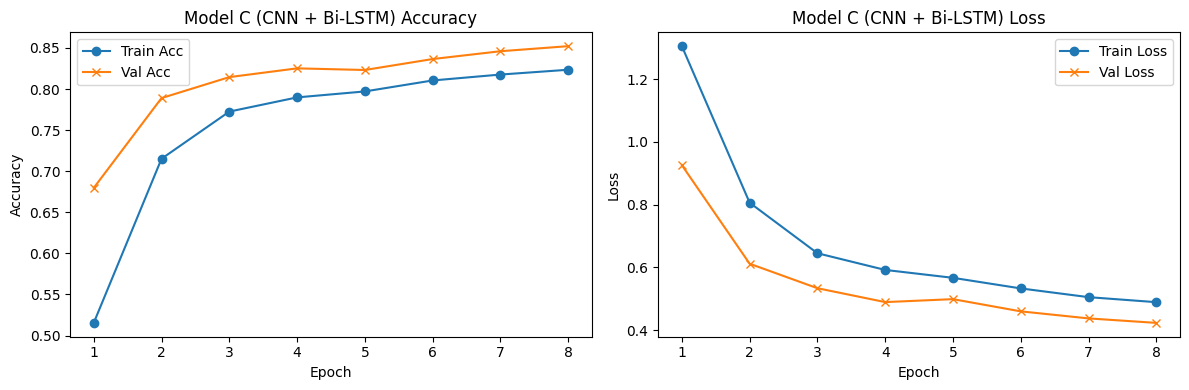

In [8]:
# ===========================================
# SECTION 7: Training Curves for 3 Models
# ===========================================

def plotHistory(history, titlePrefix="Model"):
    acc = history.history["accuracy"]
    valAcc = history.history["val_accuracy"]
    loss = history.history["loss"]
    valLoss = history.history["val_loss"]

    epochsRange = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochsRange, acc, marker="o", label="Train Acc")
    plt.plot(epochsRange, valAcc, marker="x", label="Val Acc")
    plt.title(f"{titlePrefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochsRange, loss, marker="o", label="Train Loss")
    plt.plot(epochsRange, valLoss, marker="x", label="Val Loss")
    plt.title(f"{titlePrefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plotHistory(historyA, titlePrefix="Model A (stride=2 CNN)")
plotHistory(historyB, titlePrefix="Model B (stride=1 CNN)")
plotHistory(historyC, titlePrefix="Model C (CNN + Bi-LSTM)")


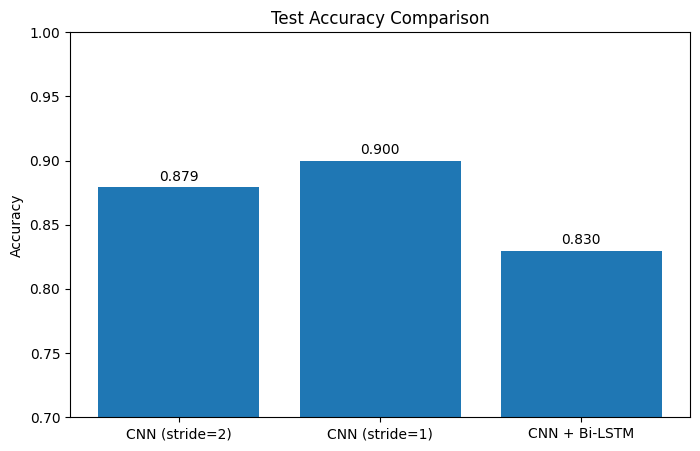

In [9]:
# ===========================================
# SECTION 8: Bar Chart Comparison
# ===========================================

modelNames = ["CNN (stride=2)", "CNN (stride=1)", "CNN + Bi-LSTM"]
testAccuracies = [accA, accB, accC]

plt.figure(figsize=(8,5))
bars = plt.bar(modelNames, testAccuracies)

for a, b in zip(bars, testAccuracies):
    plt.text(a.get_x() + a.get_width()/2, b + 0.005, f"{b:.3f}", ha="center")

plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim([0.70, 1.00])
plt.show()


Model A Confusion Matrix:


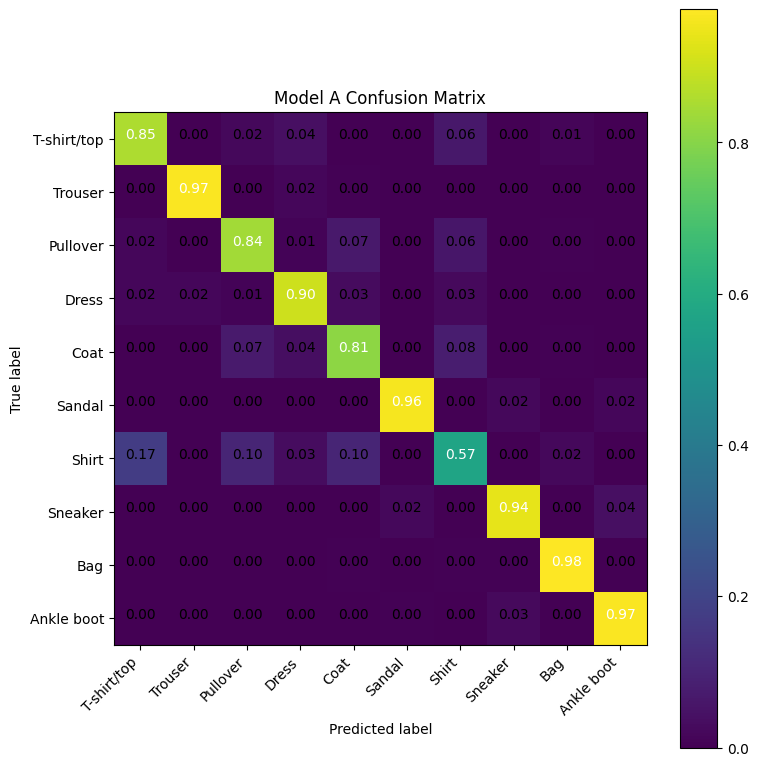

Classification report:
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.85      0.83      1000
     Trouser       0.97      0.97      0.97      1000
    Pullover       0.80      0.84      0.82      1000
       Dress       0.87      0.90      0.88      1000
        Coat       0.80      0.81      0.80      1000
      Sandal       0.97      0.96      0.97      1000
       Shirt       0.71      0.57      0.63      1000
     Sneaker       0.95      0.94      0.94      1000
         Bag       0.95      0.98      0.96      1000
  Ankle boot       0.94      0.97      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Model B Confusion Matrix:


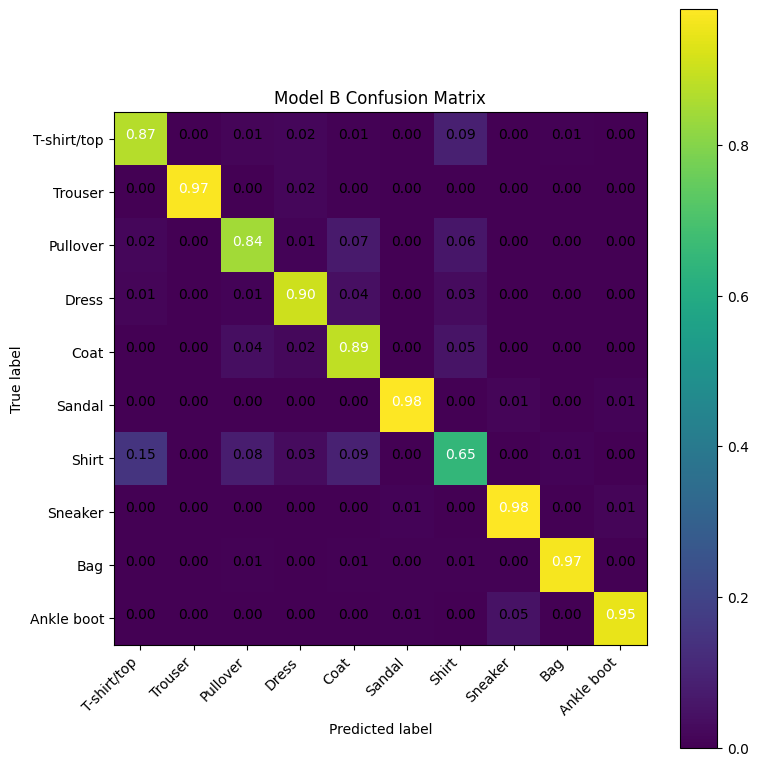

Classification report:
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.87      0.85      1000
     Trouser       1.00      0.97      0.99      1000
    Pullover       0.85      0.84      0.85      1000
       Dress       0.90      0.90      0.90      1000
        Coat       0.80      0.89      0.84      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.73      0.65      0.69      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.98      0.97      0.97      1000
  Ankle boot       0.98      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Model C Confusion Matrix:


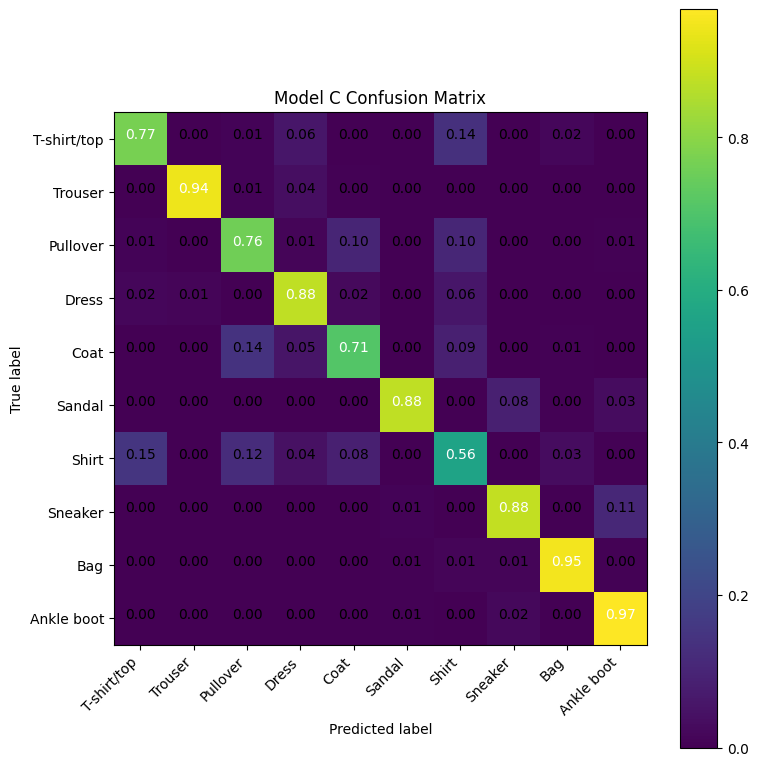

Classification report:
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.77      0.79      1000
     Trouser       0.97      0.94      0.96      1000
    Pullover       0.72      0.76      0.74      1000
       Dress       0.81      0.88      0.84      1000
        Coat       0.76      0.71      0.73      1000
      Sandal       0.97      0.88      0.92      1000
       Shirt       0.58      0.56      0.57      1000
     Sneaker       0.88      0.88      0.88      1000
         Bag       0.93      0.95      0.94      1000
  Ankle boot       0.86      0.97      0.91      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [10]:
# ===========================================
# SECTION 9: Confusion Matrices
# ===========================================

classNames = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

def plotConfusionMatrix(yTrue, yPred, classes, title="Confusion matrix", normalize=False):
    cm = confusion_matrix(yTrue, yPred)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()

    tickMarks = np.arange(len(classes))
    plt.xticks(tickMarks, classes, rotation=45, ha="right")
    plt.yticks(tickMarks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

    print("Classification report:")
    print(classification_report(yTrue, yPred, target_names=classes))


def getPredictions(model, xTest):
    yProb = model.predict(xTest, verbose=0)
    yPred = np.argmax(yProb, axis=1)
    return yPred

yPredA = getPredictions(modelA, xTest)
yPredB = getPredictions(modelB, xTest)
yPredC = getPredictions(modelC, xTest)

print("Model A Confusion Matrix:")
plotConfusionMatrix(yTestRaw, yPredA, classNames, title="Model A Confusion Matrix", normalize=True)

print("Model B Confusion Matrix:")
plotConfusionMatrix(yTestRaw, yPredB, classNames, title="Model B Confusion Matrix", normalize=True)

print("Model C Confusion Matrix:")
plotConfusionMatrix(yTestRaw, yPredC, classNames, title="Model C Confusion Matrix", normalize=True)


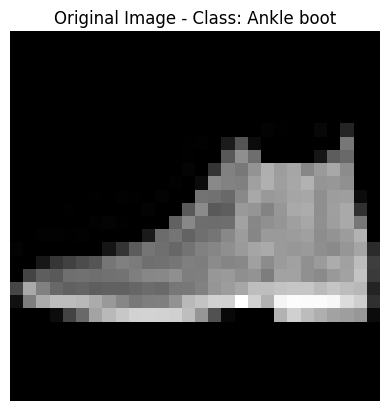

Feature maps for Model A (stride=2 CNN):


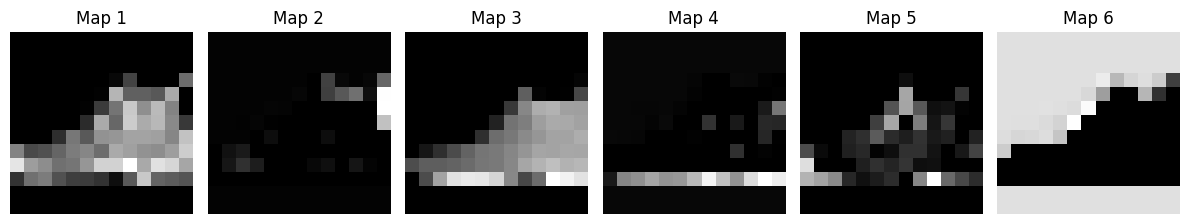

Feature maps for Model B (stride=1 CNN):


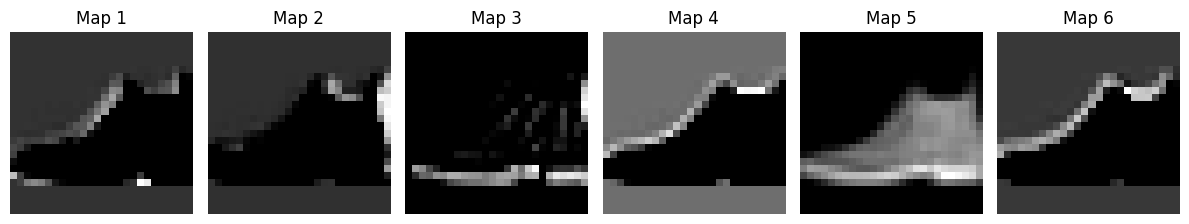

In [12]:
# ===========================================
# SECTION 10: Feature Map Visualisation
# ===========================================

def getFeatureModel(model, convLayerIndex=None):
    # make sure model is built (called at least once)
    if not model.built:
        dummyInput = np.zeros((1, 28, 28, 1), dtype=np.float32)
        _ = model(dummyInput)

    # if no index is given, pick the first Conv2D layer
    if convLayerIndex is None:
        for a, layer in enumerate(model.layers):
            if isinstance(layer, layers.Conv2D):
                convLayerIndex = a
                break

    featureModel = models.Model(
        inputs=model.inputs,
        outputs=model.layers[convLayerIndex].output
    )
    return featureModel


def showFeatureMaps(featureModel, image, numMapsToShow=6):
    imageBatch = np.expand_dims(image, axis=0)
    featureMaps = featureModel.predict(imageBatch, verbose=0)

    numFeatureMaps = featureMaps.shape[-1]
    numToShow = min(numMapsToShow, numFeatureMaps)

    plt.figure(figsize=(12, 4))

    for a in range(numToShow):
        plt.subplot(1, numToShow, a + 1)
        plt.imshow(featureMaps[0, :, :, a], cmap="gray")
        plt.axis("off")
        plt.title(f"Map {a+1}")

    plt.tight_layout()
    plt.show()


# pick a sample image
sampleIndex = 0
sampleImage = xTest[sampleIndex]

plt.imshow(sampleImage.squeeze(), cmap="gray")
plt.title(f"Original Image - Class: {classNames[yTestRaw[sampleIndex]]}")
plt.axis("off")
plt.show()

print("Feature maps for Model A (stride=2 CNN):")
featureModelA = getFeatureModel(modelA)  # auto-picks first Conv2D
showFeatureMaps(featureModelA, sampleImage, numMapsToShow=6)

print("Feature maps for Model B (stride=1 CNN):")
featureModelB = getFeatureModel(modelB)  # auto-picks first Conv2D
showFeatureMaps(featureModelB, sampleImage, numMapsToShow=6)


In [13]:
# ===========================================
# SECTION 11: Summary Table
# ===========================================

print("===== Summary of Test Performance =====")
print(f"Model A (stride=2 CNN):    Test Accuracy = {accA:.4f}")
print(f"Model B (stride=1 CNN):    Test Accuracy = {accB:.4f}")
print(f"Model C (CNN + Bi-LSTM):   Test Accuracy = {accC:.4f}")

summaryTable = {
    "Model": ["CNN (stride=2)", "CNN (stride=1)", "CNN + Bi-LSTM"],
    "Test Accuracy": [accA, accB, accC],
    "Test Loss": [lossA, lossB, lossC]
}

summaryTable


===== Summary of Test Performance =====
Model A (stride=2 CNN):    Test Accuracy = 0.8795
Model B (stride=1 CNN):    Test Accuracy = 0.8999
Model C (CNN + Bi-LSTM):   Test Accuracy = 0.8297


{'Model': ['CNN (stride=2)', 'CNN (stride=1)', 'CNN + Bi-LSTM'],
 'Test Accuracy': [0.8794999718666077, 0.8999000191688538, 0.8296999931335449],
 'Test Loss': [0.3276447653770447, 0.27118873596191406, 0.46868443489074707]}